# Import Libraries 

In [ ]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Initialize the parameters

In [ ]:
# initialize the input shape to be "channels last" along with
# the channels dimension itself
# channels dimension itself
width, height, depth = 42, 42, 1
inputShape = (42, 42, 1)
chanDim = -1

# flatten the network and then construct our latent vector
latentDim=512

# latenet square image
latenet_img_size = int(512**0.5)

# Run model params
EPOCHS = 20
BS = 64

#model number or name
model_name = "model_4_"

# Construct the Encoder Model using CNN 

In [ ]:
# define the input to the encoder
inputs = Input(shape=inputShape)
x = inputs

# apply a CONV => RELU => BN operation
x = Conv2D(128, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

# apply a CONV => RELU => BN operation
x = Conv2D(256, (3, 3), strides=3, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

volumeSize = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latentDim)(x)

# build the encoder model
encoder = Model(inputs, latent, name="encoder")

print(encoder.summary())

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 42, 42, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       1280      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 21, 21, 128)       0         
                                                                 
 batch_normalization_4 (Batc  (None, 21, 21, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         295168    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 256)         0         
                                                           

# Construct the Decoder Model with CNN (Transpose)

In [ ]:
# start building the decoder model which will accept the
# output of the encoder as its inputs
latentInputs = Input(shape=(latentDim,))
x = Dense(np.prod(volumeSize[1:]))(latentInputs)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

# loop over our number of filters again, but this time in
# reverse order

# apply a CONV_TRANSPOSE => RELU => BN operation
x = Conv2DTranspose(256, (3, 3), strides=3,
  padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

# apply a CONV_TRANSPOSE => RELU => BN operation
x = Conv2DTranspose(128, (3, 3), strides=2,
  padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

# apply a single CONV_TRANSPOSE layer used to recover the
# original depth of the image
x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
outputs = Activation("sigmoid")(x)

# build the decoder model
decoder = Model(latentInputs, outputs, name="decoder")
print(decoder.summary())


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_4 (Dense)             (None, 12544)             6435072   
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 21, 21, 256)      590080    
 ranspose)                                                       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 21, 21, 256)       0         
                                                                 
 batch_normalization_8 (Batc  (None, 21, 21, 256)      1024      
 hNormalization)                                           

# Construct the Autoencoder (Encoder + Decoder)

In [ ]:
# our autoencoder is the encoder + decoder
autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
print(autoencoder.summary())

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 42, 42, 1)]       0         
                                                                 
 encoder (Functional)        (None, 512)               6721024   
                                                                 
 decoder (Functional)        (None, 42, 42, 1)         7322881   
                                                                 
Total params: 14,043,905
Trainable params: 14,042,369
Non-trainable params: 1,536
_________________________________________________________________
None


**Save the model diagrams**

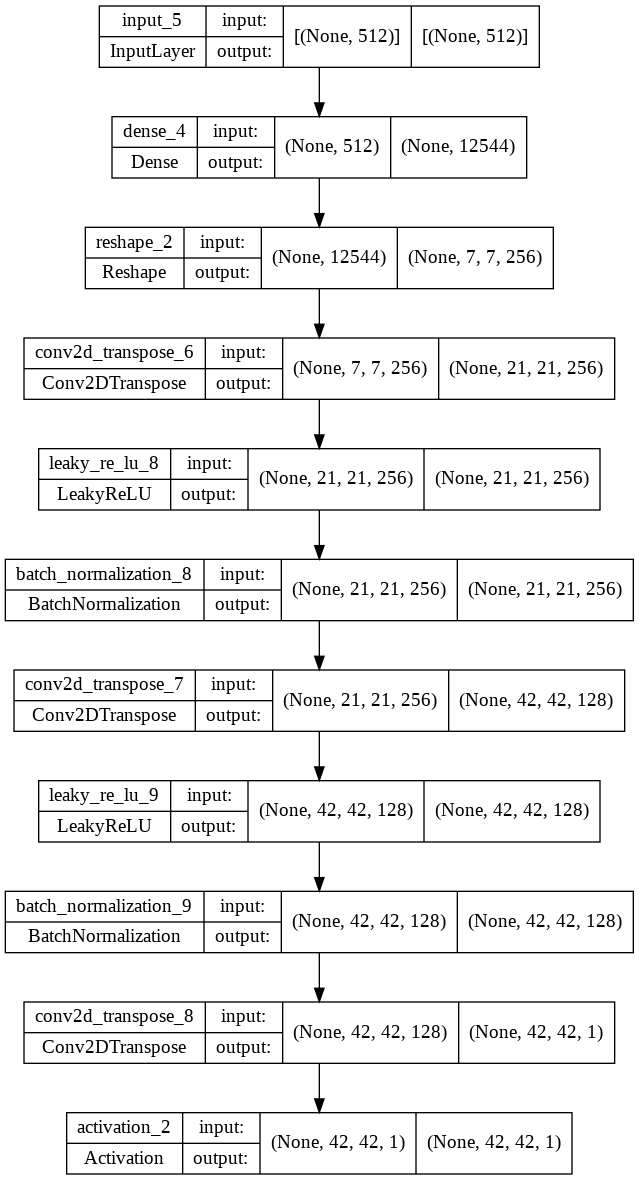

In [ ]:
from keras.utils.vis_utils import plot_model
base_path_graphs = "/content/drive/My Drive/Google_Colab/Autoencoder/Graphs/"

save_path = base_path_graphs + model_name + 'autoencoder.png'
plot_model(autoencoder, to_file=save_path, show_shapes=True, show_layer_names=True)

save_path = base_path_graphs + model_name + 'encoder.png'
plot_model(encoder, to_file=save_path, show_shapes=True, show_layer_names=True)

save_path = base_path_graphs + model_name + 'decoder.png'
plot_model(decoder, to_file=save_path, show_shapes=True, show_layer_names=True)


# Import and resize the dataset accordingly

In [ ]:
# import dataset
# initialize the number of epochs to train for and batch size
import pandas as pd

print("[INFO] loading Imagenet dataset...")
trainX = pd.read_csv('/content/drive/My Drive/Google_Colab/tiny_imagenet/tiny_imagenet_1000_42x42_2.csv')  
print(trainX.shape)

trainX = np.array(trainX)
trainX = trainX.reshape([10000, 42,42])
print(trainX.shape)

testX = trainX
# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0
print(trainX.shape, testX.shape)

[INFO] loading Imagenet dataset...
(10000, 1764)
(10000, 42, 42)
(10000, 42, 42, 1) (10000, 42, 42, 1)


# Creating checkpoints for simulation

In [ ]:
# check points and early stopping
filepath="/content/drive/My Drive/Google_Colab/Autoencoder/saved_checkpoints/"  + model_name + "weights-improvement-{epoch:02d}-{val_loss:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [es, checkpoint]

/content/drive/My Drive/Google_Colab/Autoencoder/saved_checkpoints/model_4_weights-improvement-{epoch:02d}-{val_loss:.4f}.hdf5


# Load saved model and simulate

In [ ]:
autoencoder_loaded = load_model('/content/drive/My Drive/Google_Colab/Autoencoder/saved_checkpoints/model_s_1_weights-improvement-01-0.0679.hdf5')

H = autoencoder_loaded.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS,
	callbacks= callbacks_list
	)

Epoch 1/20
157/157 [==============================] - ETA: 0s - loss: 0.0165
Epoch 1: val_loss improved from inf to 0.05613, saving model to /content/drive/My Drive/Google_Colab/Autoencoder/saved_checkpoints/model_4_weights-improvement-01-0.0561.hdf5
157/157 [==============================] - 21s 62ms/step - loss: 0.0165 - val_loss: 0.0561
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 0.0136
Epoch 2: val_loss improved from 0.05613 to 0.03728, saving model to /content/drive/My Drive/Google_Colab/Autoencoder/saved_checkpoints/model_4_weights-improvement-02-0.0373.hdf5
157/157 [==============================] - 9s 59ms/step - loss: 0.0136 - val_loss: 0.0373
Epoch 3/20
157/157 [==============================] - ETA: 0s - loss: 0.0121
Epoch 3: val_loss improved from 0.03728 to 0.01570, saving model to /content/drive/My Drive/Google_Colab/Autoencoder/saved_checkpoints/model_4_weights-improvement-03-0.0157.hdf5
157/157 [==============================] - 9s 60ms/step - 

# Simulate 

In [ ]:
# Run model 2

autoencoder.compile(loss="mse", optimizer='adam')
# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS,
	callbacks= callbacks_list
	)

Epoch 1/20
156/157 [============================>.] - ETA: 0s - loss: 0.0310
Epoch 1: val_loss did not improve from 0.00397
157/157 [==============================] - 10s 57ms/step - loss: 0.0310 - val_loss: 0.0704
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 0.0169
Epoch 2: val_loss did not improve from 0.00397
157/157 [==============================] - 9s 55ms/step - loss: 0.0169 - val_loss: 0.0549
Epoch 3/20
157/157 [==============================] - ETA: 0s - loss: 0.0136
Epoch 3: val_loss did not improve from 0.00397
157/157 [==============================] - 9s 55ms/step - loss: 0.0136 - val_loss: 0.0373
Epoch 4/20
157/157 [==============================] - ETA: 0s - loss: 0.0120
Epoch 4: val_loss did not improve from 0.00397
157/157 [==============================] - 9s 56ms/step - loss: 0.0120 - val_loss: 0.0158
Epoch 5/20
157/157 [==============================] - ETA: 0s - loss: 0.0108
Epoch 5: val_loss did not improve from 0.00397
157/157 [==========

**Save the models**

In [ ]:
base_path_model = "/content/drive/My Drive/Google_Colab/Autoencoder/saved_models/" 
loss = "_loss_0.0041"

path_autoencoder = base_path_model + model_name+ "autoencoder" +loss + ".h5"
autoencoder.save(path_autoencoder)

path_encoder = base_path_model + model_name+ "encoder" +loss + ".h5"
encoder.save(path_encoder)

path_decoder = base_path_model+ model_name + "decoder" +loss + ".h5"
decoder.save(path_decoder)

# Plot Output and Graphs

**Simulation Loss graphs**

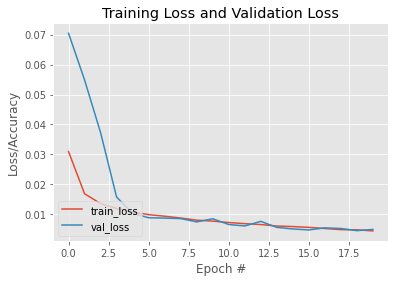

In [ ]:
# construct a plot that plots and saves the training history
import matplotlib.pyplot as plt
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

base_path_graphs = '/content/drive/My Drive/Google_Colab/Autoencoder/Graphs/'
path_loss_acc = base_path_graphs + model_name + 'Train_loss_Val_loss.png'
plt.savefig(base_path_graphs, dpi=1000, bbox_inches='tight')
#files.download( "Train_Accuracy.png" )

**Input (Original) VS Output (Generated)**

[INFO] making predictions...


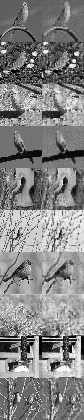

True

In [ ]:
# use the convolutional autoencoder to make predictions on the
# testing images, then initialize our list of output images
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX[:20])
outputs = None

# loop over our number of output samples
for i in range(0, 10):
	# grab the original image and reconstructed image
	original = (testX[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")
 
	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])
 
	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output

	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])
  
# save the outputs image to disk
from google.colab.patches import cv2_imshow
cv2_imshow(outputs)

import cv2
path_img = base_path_graphs + model_name + 'original_VS_generated.png'
cv2.imwrite(path_img, outputs)

**Input - Encoded - Decoded**

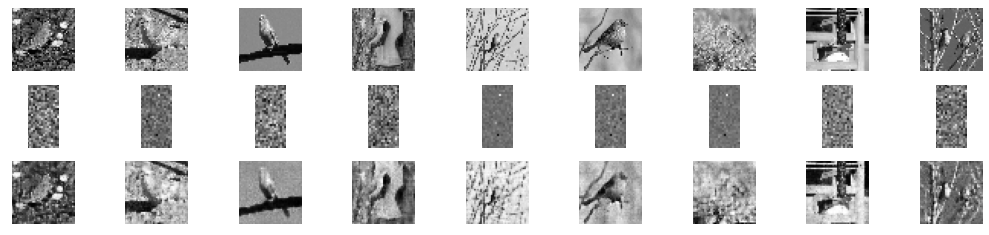

In [ ]:
encoded_imgs = encoder.predict(testX[:20])
decoded_imgs = decoder.predict(encoded_imgs)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):

    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(testX[i].reshape(42, 42))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded_imgs
    ax = plt.subplot(3, n, i + n)
    plt.imshow(encoded_imgs[i].reshape(32, 16))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display decoded_imgs
    ax = plt.subplot(3, n, i + n + n)
    plt.imshow(decoded_imgs[i].reshape(42, 42))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#plt.show()
path_img2 = base_path_graphs + model_name + 'original-encoded-decoded.png'
plt.savefig(path_img2, dpi=1000, bbox_inches='tight')

# Save and Load encoded images in a file

**Save**

In [ ]:
import numpy
base_path_encoded_dataset = "/content/drive/My Drive/Google_Colab/Autoencoder/encoded_dataset/"
path_encoded_dataset = base_path_encoded_dataset + model_name + "encoded_imgs_20.csv"
numpy.savetxt(path_encoded_dataset, encoded_imgs, delimiter=",")

**Load**

In [ ]:
import pandas as pd
encoded_imgs_file = pd.read_csv(path_encoded_dataset)  
print(encoded_imgs_file.shape)

encoded_imgs_file = np.array(encoded_imgs_file)
print(encoded_imgs_file.shape)

(19, 512)
(19, 512)


**Decode the encoded images from file**

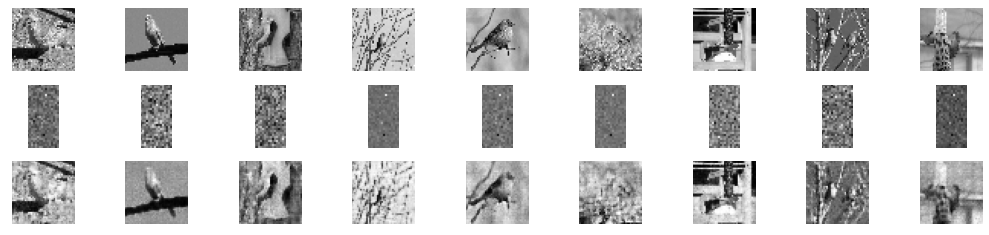

In [ ]:
decoded_imgs = decoder.predict(encoded_imgs_file)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(testX[i+1].reshape(42, 42))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded
    ax = plt.subplot(3, n, i+n)
    plt.imshow(encoded_imgs_file[i].reshape(32, 16))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n+n)
    plt.imshow(decoded_imgs[i].reshape(42, 42))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Load saved model and load encoded images from file

**Load models**

In [ ]:
#saved_model = load_model('best_model.h5')
#load_path_model = base_path_model + "model_1_loss0068.h5"
autoencoder_loaded = load_model(base_path_model + "model_4_autoencoder_loss_0.0041.h5")
encoder_loaded = load_model(base_path_model + 'model_4_encoder_loss_0.0041.h5')
decoder_loaded = load_model(base_path_model + 'model_4_decoder_loss_0.0041.h5')

**Execute the loaded models**

In [ ]:
decoded_imgs = decoder_loaded.predict(encoded_imgs_file)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(testX[i+1].reshape(42, 42))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded
    ax = plt.subplot(3, n, i+n)
    plt.imshow(encoded_imgs_file[i].reshape(32, 16))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n+n)
    plt.imshow(decoded_imgs[i].reshape(42, 42))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
! git init

Initialized empty Git repository in /content/.git/


In [ ]:
! git add .

error: open("drive/MyDrive/Copy of Simple Style Thesis Defense by Slidesgo.gslides"): Operation not supported
error: unable to index file drive/MyDrive/Copy of Simple Style Thesis Defense by Slidesgo.gslides
fatal: adding files failed


# References



*   [Autoencoder Pyimagesearch](https://www.pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/)
*   [Visualize models](https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/)
*   [Callbacks and Early stopping](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)
